In [1]:
import warnings
warnings.filterwarnings('ignore')
import geopandas as gpd
from geopandas.tools import overlay
import matplotlib.pyplot as plt
import os 
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
import xgboost as xgb
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, mean_squared_error
#import tensorflow as tf
#from keras.models import Sequential
#from keras.layers import Dense
#from tensorflow.keras.utils import to_categorical

## Espacios Públicos GDL

In [3]:
schema = 'espacios_publicos'
table = 'ep_amg'
gdf_gdl = aup.gdf_from_db(table,schema)

In [10]:
gdf_gdl.shape

(8499, 4)

## Espacios Públicos QRO

In [4]:
schema = 'espacios_publicos'
table = 'ep_qro'
gdf_qro = aup.gdf_from_db(table,schema)

In [11]:
gdf_qro.shape

(4814, 9)

## Espacios Públicos CDMX

In [5]:
schema = 'espacios_publicos'
table = 'ep_cdmx'
gdf_cdmx = aup.gdf_from_db(table,schema)

In [12]:
gdf_cdmx.shape

(11609, 13)

## Juntamos en un dataset

In [6]:
gdf_gdl = gdf_gdl.set_crs("EPSG:4326", allow_override=True)
gdf_qro = gdf_qro.set_crs("EPSG:4326", allow_override=True)
gdf_cdmx = gdf_cdmx.set_crs("EPSG:4326", allow_override=True)
print("CRS of gdf_gdl:", gdf_gdl.crs)
print("CRS of gdf_qro:", gdf_qro.crs)
print("CRS of gdf_cdmx:", gdf_cdmx.crs)

CRS of gdf_gdl: EPSG:4326
CRS of gdf_qro: EPSG:4326
CRS of gdf_cdmx: EPSG:4326


In [7]:
geodataframes = [gdf_gdl, gdf_qro, gdf_cdmx]
gdf = pd.concat(geodataframes)
gdf = gdf['geometry']
gdf.head()

0    POLYGON ((672507.02800 2272132.20130, 672520.1...
1    POLYGON ((672520.12560 2272170.35300, 672507.0...
2    POLYGON ((672494.32530 2272095.20510, 672480.3...
3    POLYGON ((672480.36630 2272060.73140, 672494.3...
4    POLYGON ((672468.71720 2272020.61270, 672456.8...
Name: geometry, dtype: geometry

In [8]:
gdf.shape

(24922,)

## Hexágonos 3 ciudades

In [9]:
hex_schema = "raster_analysis"
hex_table = "ndvi_analysis_hex"
c1 = 'Guadalajara'
c2 ='ZMVM'
c3 = 'Queretaro'
n = '11'
query = f'SELECT hex_id, geometry, city FROM {hex_schema}.{hex_table} WHERE \"city\" IN (\'{c1}\',\'{c2}\',\'{c3}\') AND \"res\" = {n}'
hex_gdl = aup.gdf_from_query(query, geometry_col='geometry')
#query = 'fSelect geometry, hex_id, city from raster_analysis.ndvi_analysis where city = guadalajara and res = 11'
hex_gdl.head(5)

,hex_id,geometry,city
0,8b49ab4b2758fff,"POLYGON ((-103.39247 20.75090, -103.39230 20.7...",Guadalajara
1,8b49ab4b270cfff,"POLYGON ((-103.39091 20.74832, -103.39074 20.7...",Guadalajara
2,8b49ab4b2792fff,"POLYGON ((-103.38489 20.74954, -103.38472 20.7...",Guadalajara
3,8b49ab4b2722fff,"POLYGON ((-103.39016 20.74679, -103.38998 20.7...",Guadalajara
4,8b49ab4b26f4fff,"POLYGON ((-103.38863 20.75304, -103.38845 20.7...",Guadalajara


In [29]:
hex_gdl.shape

(807141, 4)

In [24]:
hex_gdl['city'].unique()

array(['Guadalajara', 'Queretaro', 'ZMVM'], dtype=object)

In [10]:
contador_gdll = np.sum(hex_gdl['city'] == 'Guadalajara')
contador_cdmxx = np.sum(hex_gdl['city'] == 'ZMVM')
contador_qroo = np.sum(hex_gdl['city'] == 'Queretaro')
print(f'Número de hexágonos Gdl: {contador_gdll} \nNúmero de hexágonos Cdmx: {contador_cdmxx} \nNúmero de hexágonos Qro: {contador_qroo}')

Número de hexágonos Gdl: 407141 
Número de hexágonos Cdmx: 300000 
Número de hexágonos Qro: 100000


In [11]:
hex_gdl = hex_gdl.set_crs("EPSG:4326", allow_override=True)
print("CRS of gdf_gdl:", gdf_gdl.crs)

CRS of gdf_gdl: EPSG:4326


Como tenemos 800,000 hexágonos tenemos que reducir la dimensión a 400,000 porque mi compu no puede con tantos datos. Vamos a reducir la dimensión de las 3 ciudades a la mitad. Inicialmente, tenemos que Guadalajara tiene 400,000 hexágonos. Cdmx tiene 300,000 hexágonos y Querétaro tiene 100,000 hexágonos. Pero después de reducir las dimensiones serán 200,000; 150,000 y 50,000 respectivamente.

In [13]:
gdl_samples = 200000
cdmx_samples = 150000
qro_samples = 50000

# Randomly sample 200,000 hexagons of Guadalajra
sample_with_Guadalajara = hex_gdl[hex_gdl['city'] == 'Guadalajara'].sample(n=gdl_samples, random_state=42)

# Randomly sample 150,000 hexagons of Cdmx
sample_with_Cdmx = hex_gdl[hex_gdl['city'] == 'ZMVM'].sample(n=cdmx_samples, random_state=42)

# Randomly sample 50,000 hexagons of Queretaro
sample_with_Queretaro = hex_gdl[hex_gdl['city'] == 'Queretaro'].sample(n=qro_samples, random_state=42)

# Concatenate the two samples to get the final subsample
hex_gdf = pd.concat([sample_with_Guadalajara, sample_with_Cdmx, sample_with_Queretaro])
hex_gdf.reset_index(drop = True, inplace = True)
hex_gdf.head()

,hex_id,geometry,city
0,8b49aa2f0943fff,"POLYGON ((-103.29497 20.46059, -103.29479 20.4...",Guadalajara
1,8b498c94cd48fff,"POLYGON ((-103.35049 20.70770, -103.35032 20.7...",Guadalajara
2,8b49ab594ae1fff,"POLYGON ((-103.41820 20.60143, -103.41803 20.6...",Guadalajara
3,8b49ab5b2511fff,"POLYGON ((-103.40008 20.57395, -103.39991 20.5...",Guadalajara
4,8b498c955971fff,"POLYGON ((-103.27315 20.67382, -103.27297 20.6...",Guadalajara


In [14]:
contador_gdl = np.sum(hex_gdf['city'] == 'Guadalajara')
contador_cdmx = np.sum(hex_gdf['city'] == 'ZMVM')
contador_qro = np.sum(hex_gdf['city'] == 'Queretaro')
print(f'Número de hexágonos Gdl: {contador_gdl} \nNúmero de hexágonos Cdmx: {contador_cdmx} \nNúmero de hexágonos Qro: {contador_qro}')

Número de hexágonos Gdl: 200000 
Número de hexágonos Cdmx: 150000 
Número de hexágonos Qro: 50000


## Dummy Variables
1 = Hexágonos que cuentan con espacios públicos

0 = Hexágonos que no cuentan con espacios públicos

In [15]:
gdf_sindex = gdf.sindex

# Create a Series of boolean values indicating which hexagons intersect with public spaces
intersects_public_spaces = hex_gdf['geometry'].apply(lambda geom: any(gdf_sindex.query(geom)))

hex_gdf['EspPublico'] = intersects_public_spaces.astype(int)
hex_gdf.head()

,hex_id,geometry,city,EspPublico
0,8b49aa2f0943fff,"POLYGON ((-103.29497 20.46059, -103.29479 20.4...",Guadalajara,0
1,8b498c94cd48fff,"POLYGON ((-103.35049 20.70770, -103.35032 20.7...",Guadalajara,0
2,8b49ab594ae1fff,"POLYGON ((-103.41820 20.60143, -103.41803 20.6...",Guadalajara,0
3,8b49ab5b2511fff,"POLYGON ((-103.40008 20.57395, -103.39991 20.5...",Guadalajara,0
4,8b498c955971fff,"POLYGON ((-103.27315 20.67382, -103.27297 20.6...",Guadalajara,0


In [16]:
contador_ceros = np.sum(hex_gdf['EspPublico'] == 0)
contador_uno = np.sum(hex_gdf['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {contador_ceros} \nNúmero de Hexágonos con Espacios Públicos: {contador_uno}\nNúmero total de Hexágonos: {contador_ceros+contador_uno}')

Números de hexagonos sin Espacios Públicos: 353125 
Número de Hexágonos con Espacios Públicos: 46875
Número total de Hexágonos: 400000


## Hexágonos con info de humedad, vegetación y temperatura

select {ndmi}.hex_id, {ndmi}.geometry, {ndmi}.city, {ndmi}.res,

ndvi_mean, ndvi_std, ndvi_median, ndvi_max, ndvi_min, ndvi_diff, ndvi_tend,

ndmi_mean, ndmi_median, ndmi_diff

from raster_analysis.ndmi_analysis_hex ndmi

inner join raster_analysis.ndvi_analysis_hex ndvi

on ndmi.hex_id = ndvi.hex_id 

where ndmi.city  in ('Queretaro','Guadalajara','ZMVM') and ndmi.res = 11

In [17]:
hex_schema = "raster_analysis"
hex_tablee = "ndvi_analysis_hex"
hex_table = "ndmi_analysis_hex"
ndmi = "ndmi"
ndvi = "ndvi"
hex_id = "hex_id"
c1 = 'Guadalajara'
c2 ='ZMVM'
c3 = 'Queretaro'
n = '11'
query = f'SELECT {ndmi}.hex_id, {ndmi}.geometry, {ndmi}.city, {ndmi}.res, ndvi_mean, ndvi_std, ndvi_median, ndvi_max, ndvi_min, ndvi_diff, ndvi_tend,ndmi_mean, ndmi_median, ndmi_diff FROM {hex_schema}.{hex_table} {ndmi} INNER JOIN {hex_schema}.{hex_tablee} {ndvi} ON {ndmi}.{hex_id} = {ndvi}.{hex_id} WHERE {ndmi}.\"city\" IN (\'{c1}\',\'{c2}\',\'{c3}\') AND {ndmi}.\"res\" = {n}'
intt_gdl = aup.gdf_from_query(query, geometry_col='geometry')
intt_gdl.head(10)

,hex_id,geometry,city,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndmi_mean,ndmi_median,ndmi_diff
0,8b49ab4b2670fff,"POLYGON ((-103.39190 20.75208, -103.39172 20.7...",Guadalajara,11,0.264131,0.056046,0.278143,0.308765,0.173648,0.135117,-0.000757,0.053463,0.050777,0.097573
1,8b498c949b6dfff,"POLYGON ((-103.38527 20.75031, -103.38509 20.7...",Guadalajara,11,0.135261,0.035197,0.142945,0.161384,0.089809,0.071574,-0.001371,-0.006434,-0.016396,0.129264
2,8b49ab59516efff,"POLYGON ((-103.43305 20.61173, -103.43288 20.6...",Guadalajara,11,0.069822,0.019254,0.073560,0.082880,0.038931,0.043949,-0.000442,-0.074391,-0.088315,0.145272
3,8b49ab5951b5fff,"POLYGON ((-103.42548 20.61037, -103.42530 20.6...",Guadalajara,11,0.075444,0.033387,0.082717,0.102821,0.043347,0.059474,-0.001355,-0.076039,-0.093632,0.151256
4,8b498c865b9bfff,"POLYGON ((-103.35087 20.78574, -103.35070 20.7...",Guadalajara,11,0.414932,0.215705,0.409933,0.706465,0.117555,0.588910,-0.002985,0.014976,0.008282,0.426409
5,8b49ab59a071fff,"POLYGON ((-103.42430 20.68631, -103.42412 20.6...",Guadalajara,11,0.097393,0.022015,0.102658,0.116272,0.062223,0.054049,-0.000619,-0.015337,-0.023594,0.136351
6,8b49ab59a1a3fff,"POLYGON ((-103.41923 20.68246, -103.41906 20.6...",Guadalajara,11,0.106788,0.026689,0.118256,0.123394,0.063510,0.059884,-0.000830,-0.031611,-0.046093,0.146642
7,8b49ab59a196fff,"POLYGON ((-103.41691 20.68300, -103.41674 20.6...",Guadalajara,11,0.112221,0.026121,0.121259,0.128715,0.073114,0.055601,-0.000830,-0.040496,-0.051069,0.124201
8,8b49ab59a082fff,"POLYGON ((-103.41790 20.68676, -103.41773 20.6...",Guadalajara,11,0.166674,0.040736,0.181126,0.203151,0.091123,0.112028,-0.001068,-0.012072,-0.020578,0.118349
9,8b49ab584629fff,"POLYGON ((-103.47303 20.60176, -103.47286 20.6...",Guadalajara,11,0.394442,0.146691,0.418936,0.521344,0.185360,0.335984,-0.003164,0.022051,0.025598,0.208958


In [18]:
intt_gdl.shape

(799837, 14)

In [34]:
intt_gdl['city'].unique()

array(['Guadalajara', 'Queretaro', 'ZMVM'], dtype=object)

In [19]:
intt_gdll = np.sum(intt_gdl['city'] == 'Guadalajara')
intt_cdmxx = np.sum(intt_gdl['city'] == 'ZMVM')
intt_qroo = np.sum(intt_gdl['city'] == 'Queretaro')
print(f'Número de hexágonos Gdl: {intt_gdll} \nNúmero de hexágonos Cdmx: {intt_cdmxx} \nNúmero de hexágonos Qro: {intt_qroo}')

Número de hexágonos Gdl: 400000 
Número de hexágonos Cdmx: 299918 
Número de hexágonos Qro: 99919


Como tenemos 800,000 hexágonos tenemos que reducir la dimensión a 400,000 porque mi compu no puede con tantos datos. Vamos a reducir la dimensión de las 3 ciudades a la mitad. Inicialmente, tenemos que Guadalajara tiene 400,000 hexágonos. Cdmx tiene 300,000 hexágonos y Querétaro tiene 100,000 hexágonos. Pero después de reducir las dimensiones serán 200,000; 150,000 y 50,000 respectivamente.

In [20]:
gdl_samples_int = 200000
cdmx_samples_int = 150000
qro_samples_int = 50000

# Randomly sample 200,000 hexagons of Guadalajra
sample_with_Guadalajara = intt_gdl[intt_gdl['city'] == 'Guadalajara'].sample(n=gdl_samples_int, random_state=42)

# Randomly sample 150,000 hexagons of Cdmx
sample_with_Cdmx = intt_gdl[intt_gdl['city'] == 'ZMVM'].sample(n=cdmx_samples_int, random_state=42)

# Randomly sample 50,000 hexagons of Queretaro
sample_with_Queretaro = intt_gdl[intt_gdl['city'] == 'Queretaro'].sample(n=qro_samples_int, random_state=42)

# Concatenate the two samples to get the final subsample
int_gdf = pd.concat([sample_with_Guadalajara, sample_with_Cdmx, sample_with_Queretaro])
int_gdf.reset_index(drop = True, inplace = True)
int_gdf.head()

,hex_id,geometry,city,res,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndmi_mean,ndmi_median,ndmi_diff
0,8b49aa2c2463fff,"POLYGON ((-103.29765 20.53338, -103.29747 20.5...",Guadalajara,11,0.347040,0.158243,0.320887,0.551674,0.156183,0.395491,-0.001260,-0.051965,-0.041315,0.362261
1,8b49aa29bb0bfff,"POLYGON ((-103.16160 20.50368, -103.16143 20.5...",Guadalajara,11,0.360856,0.227557,0.258495,0.772629,0.148347,0.624283,-0.002090,-0.027797,-0.095338,0.490674
2,8b49aa25d881fff,"POLYGON ((-103.48573 20.49146, -103.48555 20.4...",Guadalajara,11,0.405083,0.171210,0.389650,0.629937,0.230272,0.399664,-0.002886,0.064263,0.041841,0.307760
3,8b498c9a1352fff,"POLYGON ((-103.05785 20.62443, -103.05767 20.6...",Guadalajara,11,0.243744,0.069161,0.255205,0.296221,0.189846,0.106375,-0.002875,-0.034529,-0.039428,0.102687
4,8b49aa26a415fff,"POLYGON ((-103.52286 20.45477, -103.52269 20.4...",Guadalajara,11,0.222465,0.070342,0.217360,0.301049,0.134053,0.166995,-0.001676,-0.041573,-0.051140,0.138796


In [21]:
int_gdf.shape

(400000, 14)

In [22]:
contador_gdl = np.sum(int_gdf['city'] == 'Guadalajara')
contador_cdmx = np.sum(int_gdf['city'] == 'ZMVM')
contador_qro = np.sum(int_gdf['city'] == 'Queretaro')
print(f'Número de hexágonos Gdl: {contador_gdl} \nNúmero de hexágonos Cdmx: {contador_cdmx} \nNúmero de hexágonos Qro: {contador_qro}')

Número de hexágonos Gdl: 200000 
Número de hexágonos Cdmx: 150000 
Número de hexágonos Qro: 50000


Ahora que ya tenemos dimensiones más pequeñas ya podemos hacer la intersección.

## Intersección

In [23]:
int_gdf = int_gdf.set_crs("EPSG:4326")
hex_gdf = hex_gdf.set_crs("EPSG:4326")

In [24]:
inter = gpd.sjoin(hex_gdf, int_gdf, op='intersects')

In [25]:
inter.drop(columns=['index_right','city_right','res','hex_id_right'], inplace=True)
inter.rename(columns={"hex_id_left": "hex_id","city_left": "city"}, inplace=True)
inter.head()

,hex_id,geometry,city,EspPublico,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndmi_mean,ndmi_median,ndmi_diff
0,8b49aa2f0943fff,"POLYGON ((-103.29497 20.46059, -103.29479 20.4...",Guadalajara,0,0.326641,0.239111,0.20963,0.801521,0.110195,0.691326,-0.00012,0.009815,-0.051656,0.585544
71467,8b49aa2f0944fff,"POLYGON ((-103.29507 20.45962, -103.29489 20.4...",Guadalajara,0,0.326641,0.239111,0.20963,0.801521,0.110195,0.691326,-0.00012,0.009815,-0.051656,0.585544
77404,8b49aa2f0941fff,"POLYGON ((-103.29544 20.46038, -103.29527 20.4...",Guadalajara,0,0.326641,0.239111,0.20963,0.801521,0.110195,0.691326,-0.00012,0.009815,-0.051656,0.585544
79433,8b49aa2f0945fff,"POLYGON ((-103.29549 20.45990, -103.29532 20.4...",Guadalajara,0,0.326641,0.239111,0.20963,0.801521,0.110195,0.691326,-0.00012,0.009815,-0.051656,0.585544
117165,8b49aa2f0946fff,"POLYGON ((-103.29459 20.45982, -103.29442 20.4...",Guadalajara,0,0.326641,0.239111,0.20963,0.801521,0.110195,0.691326,-0.00012,0.009815,-0.051656,0.585544


In [26]:
pd.isna(inter).sum()

hex_id         0
geometry       0
city           0
EspPublico     0
ndvi_mean      0
ndvi_std       0
ndvi_median    0
ndvi_max       0
ndvi_min       0
ndvi_diff      0
ndvi_tend      0
ndmi_mean      0
ndmi_median    0
ndmi_diff      0
dtype: int64

In [27]:
contador_gdl = np.sum(inter['city'] == 'Guadalajara')
contador_cdmx = np.sum(inter['city'] == 'ZMVM')
contador_qro = np.sum(inter['city'] == 'Queretaro')
print(f'Número de hexágonos Gdl: {contador_gdl} \nNúmero de hexágonos Cdmx: {contador_cdmx} \nNúmero de hexágonos Qro: {contador_qro}')

Número de hexágonos Gdl: 681587 
Número de hexágonos Cdmx: 519747 
Número de hexágonos Qro: 169625


In [28]:
cont_ceros = np.sum(inter['EspPublico'] == 0)
cont_uno = np.sum(inter['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {cont_ceros} \nNúmero de Hexágonos con Espacios Públicos: {cont_uno}\nNúmero total de Hexágonos: {cont_ceros+cont_uno}')

Números de hexagonos sin Espacios Públicos: 1208549 
Número de Hexágonos con Espacios Públicos: 162410
Número total de Hexágonos: 1370959


## Submuestreo 162,410 Hexágonos Esp Púb x 162,410 Hexágonos No Esp Púb

In [30]:
num_samples = len(inter[inter['EspPublico'] == 1])

# Randomly sample 203,570 hexagons with public spaces
sample_with_public_spaces = inter[inter['EspPublico'] == 1].sample(n=num_samples, random_state=42)

# Randomly sample 203,570 hexagons without public spaces
sample_without_public_spaces = inter[inter['EspPublico'] == 0].sample(n=num_samples, random_state=42)

# Concatenate the two samples to get the final subsample
inter = pd.concat([sample_with_public_spaces, sample_without_public_spaces])
inter.reset_index(drop = True, inplace = True)
inter.head()

,hex_id,geometry,city,EspPublico,ndvi_mean,ndvi_std,ndvi_median,ndvi_max,ndvi_min,ndvi_diff,ndvi_tend,ndmi_mean,ndmi_median,ndmi_diff
0,8b499585c141fff,"POLYGON ((-99.14159 19.32367, -99.14142 19.323...",ZMVM,1,0.259754,0.083176,0.286260,0.337131,0.151175,0.185957,-0.001629,0.063094,0.049319,0.148635
1,8b4995b337a8fff,"POLYGON ((-99.25771 19.36773, -99.25754 19.367...",ZMVM,1,0.134413,0.040714,0.136816,0.190439,0.083981,0.106458,0.000710,-0.014420,-0.028005,0.153273
2,8b4995ba565efff,"POLYGON ((-99.19216 19.40124, -99.19198 19.401...",ZMVM,1,0.111182,0.047319,0.125387,0.166100,0.022817,0.143282,-0.000658,0.013868,0.003817,0.118145
3,8b4995846651fff,"POLYGON ((-99.14182 19.28818, -99.14164 19.288...",ZMVM,1,0.374869,0.129211,0.426340,0.501915,0.156982,0.344933,-0.002069,0.103396,0.093925,0.125970
4,8b4995b8cca4fff,"POLYGON ((-99.17429 19.47673, -99.17412 19.476...",ZMVM,1,0.217099,0.095742,0.236790,0.347933,0.068282,0.279651,0.000113,-0.013457,-0.023668,0.207983


In [31]:
contador_ceros = np.sum(inter['EspPublico'] == 0)
contador_uno = np.sum(inter['EspPublico'])
print(f'Números de hexagonos sin Espacios Públicos: {contador_ceros} \nNúmero de Hexágonos con Espacios Públicos: {contador_uno}\nNúmero total de Hexágonos: {contador_ceros+contador_uno}')

Números de hexagonos sin Espacios Públicos: 162410 
Número de Hexágonos con Espacios Públicos: 162410
Número total de Hexágonos: 324820


In [32]:
inter.shape

(324820, 14)

## Métodos de Clasificación

In [33]:
x = inter[['ndvi_mean','ndvi_std','ndvi_median','ndvi_max','ndvi_min','ndvi_diff','ndvi_tend','ndmi_mean','ndmi_median','ndmi_diff']]
y = inter['EspPublico']

In [34]:
y.unique()

array([1, 0])

### Regresión Logística

In [35]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2, random_state = 42)
scaler = StandardScaler()
x_train_scale = scaler.fit_transform(x_train)
x_test_scale = scaler.fit_transform(x_test)

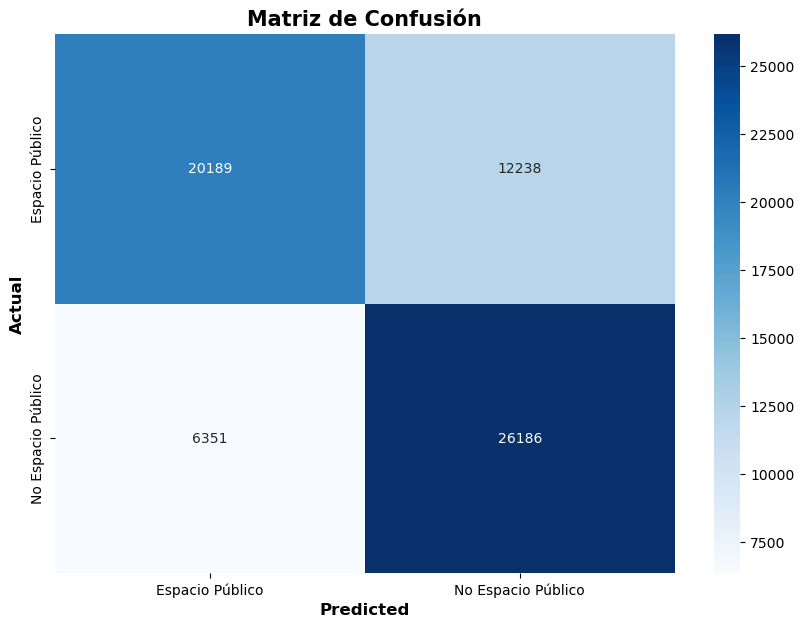

In [36]:
clf = LogisticRegression()
clf.fit(x_train_scale, y_train)
y_pred = clf.predict(x_test_scale)
cm = confusion_matrix(y_test,y_pred)
class_labels = ['Espacio Público', 'No Espacio Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [37]:
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7138569053629703


### Naive Bayes

In [38]:
nb = GaussianNB()
nb.fit(x_train, y_train)

GaussianNB()

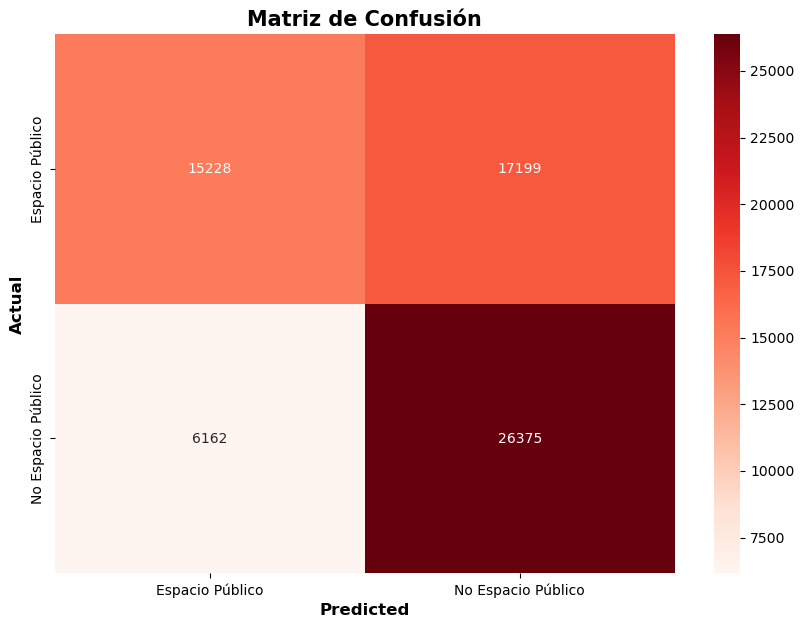

In [39]:
y_prend = nb.predict(x_test)
cm = confusion_matrix(y_test, y_prend)
class_labels = ['Espacio Público', 'No Espacio Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="Reds", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [40]:
accuracy = accuracy_score(y_test, y_prend)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6404008373868604


## Random Forest Classifier (RFC)

In [41]:
rf = RandomForestClassifier(n_estimators=120, random_state=42)  
rf.fit(x_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_predd = rf.predict(x_test)

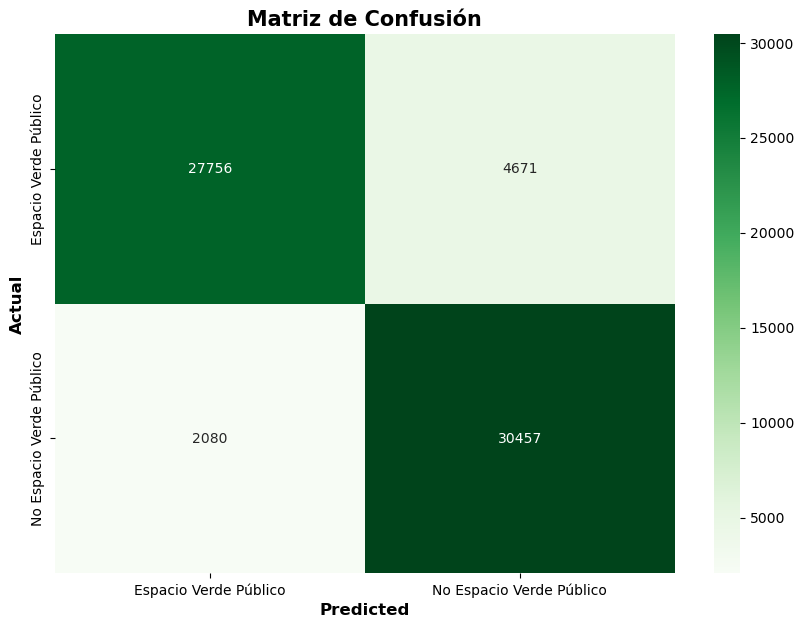

In [42]:
cm = confusion_matrix(y_test, y_predd)
class_labels = ['Espacio Verde Público', 'No Espacio Verde Público']
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, fmt = "g", cmap="Greens", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted', fontsize = 12, fontweight  = 'bold')
plt.ylabel('Actual', fontsize = 12, fontweight  = 'bold')
plt.title('Matriz de Confusión', fontsize = 15, fontweight = 'bold')
plt.show()

In [43]:
accuracy = accuracy_score(y_test, y_predd)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8960809063481313
